Firt name: Kamiar (Kamy)\
Last name: Asgari (Gary)\
USC ID: 4590556658\
Github Username: kamiarasgari

# 1. Time Series Classification Part 1: Feature Creation/Extraction

In [1]:
import numpy as np
import pandas as pd
import glob
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import warnings
warnings.filterwarnings('ignore')
Random_state = 1

## (1-a) dataset

In [2]:
root = '../data/AReM/'
folders = ['bending1' , 'bending2' , 'cycling' , 'lying' , 'sitting' , 'standing' , 'walking']

## (1-b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [3]:
test_directory = ['../data/AReM/bending1/dataset1.csv' , '../data/AReM/bending1/dataset2.csv' ,
                  '../data/AReM/bending2/dataset1.csv' , '../data/AReM/bending2/dataset2.csv' , 
                  '../data/AReM/cycling/dataset1.csv' , '../data/AReM/cycling/dataset2.csv' , '../data/AReM/cycling/dataset3.csv' , 
                  '../data/AReM/lying/dataset1.csv' , '../data/AReM/lying/dataset2.csv' , '../data/AReM/lying/dataset3.csv' , 
                  '../data/AReM/sitting/dataset1.csv' , '../data/AReM/sitting/dataset2.csv' , '../data/AReM/sitting/dataset3.csv' ,
                  '../data/AReM/standing/dataset1.csv' , '../data/AReM/standing/dataset2.csv' , '../data/AReM/standing/dataset3.csv' ,
                  '../data/AReM/walking/dataset1.csv' , '../data/AReM/walking/dataset2.csv' , '../data/AReM/walking/dataset3.csv']

X_test = []
X_train = []
y_test = []
y_train = []
for i in range(len(folders)):
    directory = root + folders[i] +'/*.csv'
    for file in glob.glob(directory):
        try:
            csv = pd.read_csv(file, skiprows=5, header=None, dtype=float)
        except Exception as e:
            csv = pd.read_csv(file, skiprows=5, header=None, dtype=float, sep='\\s+') # handles the bending2/dataset4.csv
        
        # making all 480
        temp = csv.values
        a,b = np.shape(temp)
        if a!=480:
            temp = np.vstack((temp, temp[-1]))
       
        # append 
        if file in test_directory:
            X_test.append(temp)
            y_test.append(folders[i])
        else:
            X_train.append(temp)
            y_train.append(folders[i])

## (1-c-i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Other than minimum, maximum, mean, we can use:
- standard deviation
- first quartile
- third quartile
- distribution
- entropy
- Autocorrelation
- stationarity
- Kurtosis
- scaling properties

## (1-c-ii) Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [4]:
new_label = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
new_label_numbered = []
for j in range(6):    
    for i in range(len(new_label)):
        new_label_numbered.append(new_label[i]+'_'+str(j+1))        

In [5]:
# train data
new_train_stats = np.zeros((7*6,len(X_train)))

for k in range(len(X_train)):
    x = X_train[k]

    new_train_stats[0::7,k] = np.min(x[: , 1:], axis=0)
    new_train_stats[1::7,k] = np.max(x[: , 1:], axis=0)
    new_train_stats[2::7,k] = np.mean(x[: , 1:], axis=0)
    new_train_stats[3::7,k] = np.median(x[: , 1:], axis=0)
    new_train_stats[4::7,k] = np.std(x[: , 1:], axis=0)
    new_train_stats[5::7,k] = np.percentile(x[: , 1:], 25, axis=0)
    new_train_stats[6::7,k] = np.percentile(x[: , 1:], 75, axis=0)
    
     
df_train = pd.DataFrame(data=np.transpose(new_train_stats), columns=new_label_numbered)
df_train['Label'] = y_train
print(' **************** trainig data **************** ')
#print(df_train)

# test data
new_test_stats = np.zeros((7*6,len(X_test)))

for k in range(len(X_test)):
    x = X_test[k]

    new_test_stats[0::7,k] = np.min(x[: , 1:], axis=0)
    new_test_stats[1::7,k] = np.max(x[: , 1:], axis=0)
    new_test_stats[2::7,k] = np.mean(x[: , 1:], axis=0)
    new_test_stats[3::7,k] = np.median(x[: , 1:], axis=0)
    new_test_stats[4::7,k] = np.std(x[: , 1:], axis=0)
    new_test_stats[5::7,k] = np.percentile(x[: , 1:], 25, axis=0)
    new_test_stats[6::7,k] = np.percentile(x[: , 1:], 75, axis=0)
        
df_test = pd.DataFrame(data=np.transpose(new_test_stats), columns=new_label_numbered)
df_test['Label'] = y_test
print(' **************** test data **************** ')
#print(df_test)

 **************** trainig data **************** 
 **************** test data **************** 


In [6]:
# combined trian and test dataset
combined_df = pd.concat([df_train, df_test])
# display(combined_df.reset_index(drop=True))

## (1-c-iii). Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [7]:
confidence_level = 0.9 

# print('******* trainig data ********\n')

for i in range(new_train_stats.shape[0]):
    feature_data = new_train_stats[i]
    
    # bootstrap resampling
    resampled = bs.bootstrap(feature_data, stat_func=bs_stats.std)
    
    # Calculate confidence interval
    lower_bound = resampled.lower_bound
    upper_bound = resampled.upper_bound
    
    # print(new_label_numbered[i])
    # print('Standard Deviation: ' +str(resampled.value))
    # print('Confidence Interval: ['+str(lower_bound) +', ' + str(upper_bound)+']\n')


In [8]:
# print('******* test data ********\n')

for i in range(new_test_stats.shape[0]):
    feature_data = new_test_stats[i]
    
    # bootstrap resampling
    resampled = bs.bootstrap(feature_data, stat_func=bs_stats.std)
    
    # Calculate confidence interval
    lower_bound = resampled.lower_bound
    upper_bound = resampled.upper_bound
    
    # print(new_label_numbered[i])
    # print('Standard Deviation: ' +str(resampled.value))
    # print('Confidence Interval: ['+str(lower_bound) +', ' + str(upper_bound)+']\n')


In [9]:
confidence_level = 0.9 

# print('******* All the data ********\n')

for i in range(len(new_label_numbered)):
    feature_data = np.array(combined_df[new_label_numbered[i]])
    
    # bootstrap resampling
    resampled = bs.bootstrap(feature_data, stat_func=bs_stats.std)
    
    # Calculate confidence interval
    lower_bound = resampled.lower_bound
    upper_bound = resampled.upper_bound
    
    # print(new_label_numbered[i])
    # print('Standard Deviation: ' +str(resampled.value))
    # print('Confidence Interval: ['+str(lower_bound) +', ' + str(upper_bound)+']\n')


## (1-c-iv). Use your judgement to select the three most important time-domain features (one option may be min, mean, and max)

In [10]:
newer_label_numbered = []
for i in range(len(new_label)):    
    for j in range(6):    
        newer_label_numbered.append(new_label[i]+'_'+str(j+1))        

In [11]:
# only using training data

for i in range(len(newer_label_numbered)):
    selected_data=[]
    for j in range(len(folders)):
        selected_data.append(df_train.loc[df_train['Label'] == folders[j], newer_label_numbered[i]])
    #plt.boxplot(selected_data)
    #plt.xlabel('Groups')
    #plt.title(newer_label_numbered[i])
    #plt.xticks(range(1, len(folders) + 1), folders)
    # plt.show()
    

I think the 'first quantiles' and the 'second quantiles' are giving a good way of distingushing the classes. Combined with 'mean' they should be the best three.

# ************** HW4 *************************

# 2. Time Series Classification Part 2: Binary and Multiclass Classification

## (a-i) Binary Classification Using Logistic Regression

In [12]:
selected_features = ['mean', '1st_quartile', '3rd_quartile']
selected_label = []
for i in range(len(selected_features)):    
    for j in [1,2,6]:    
        selected_label.append(selected_features[i]+'_'+str(j))        

In [13]:
df_selected = df_train[selected_label + ['Label']].copy()
df_selected['class'] = (df_train['Label'] == 'bending1') | (df_train['Label'] == 'bending2')

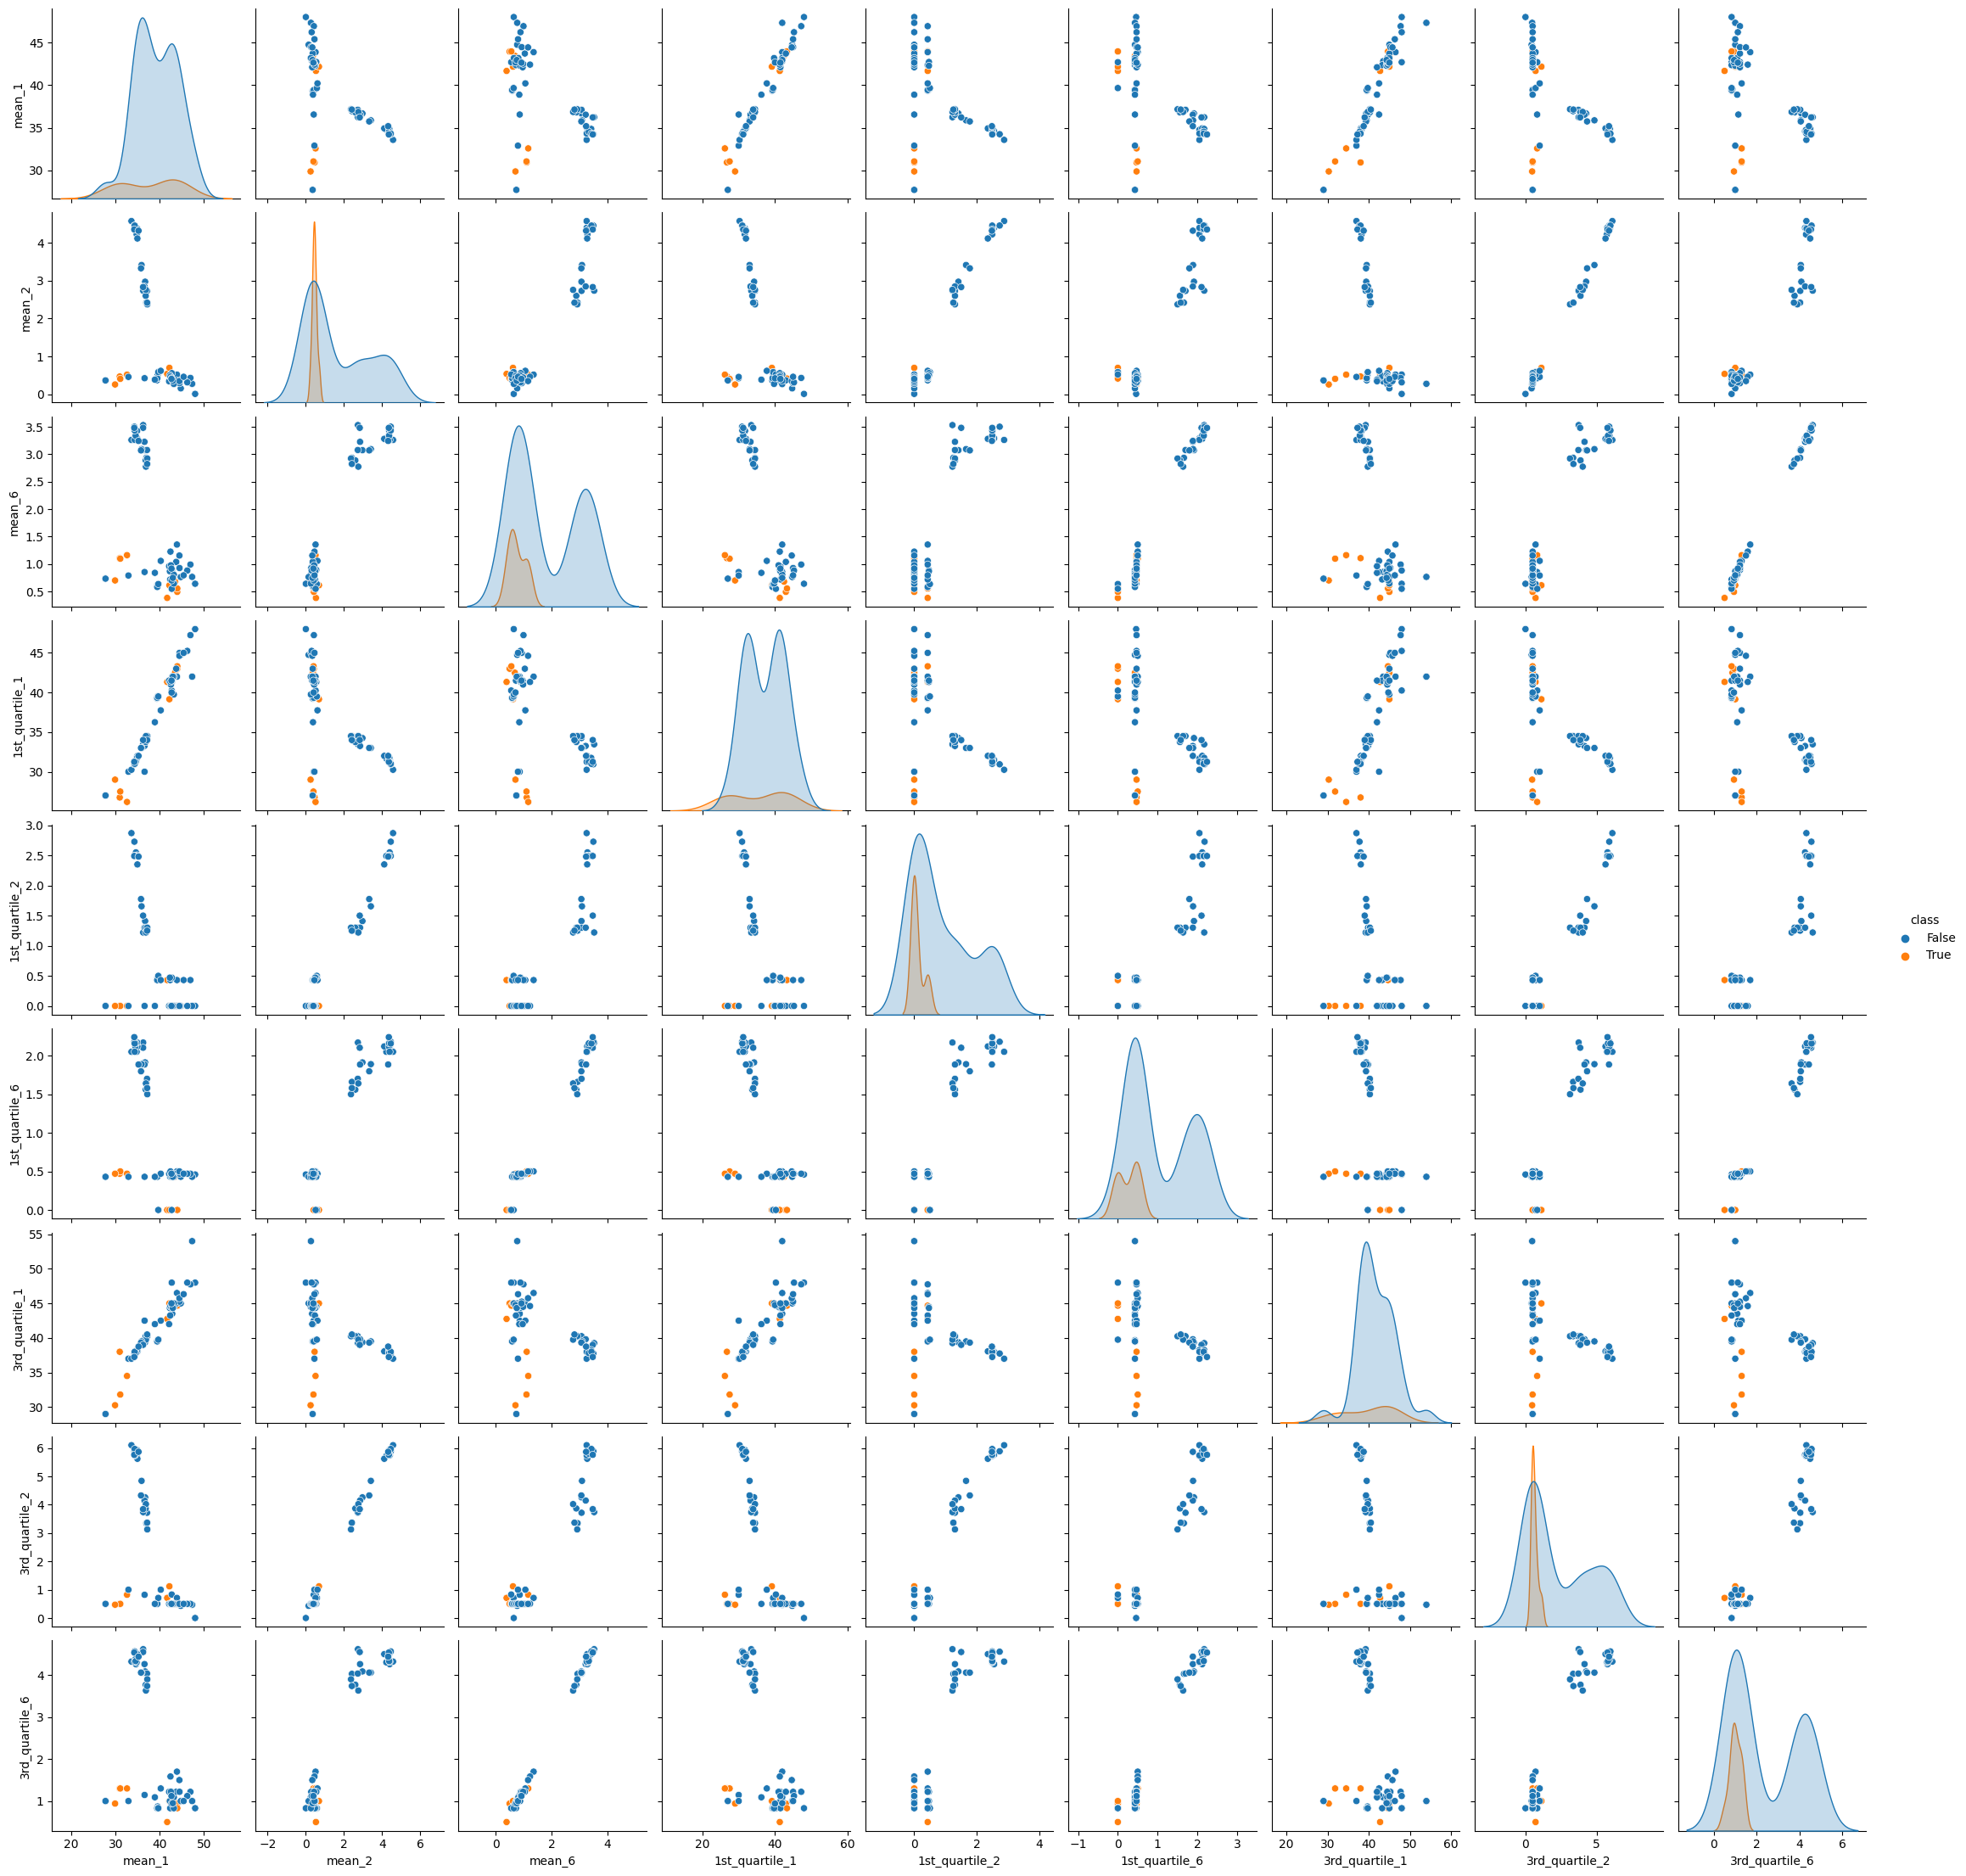

In [14]:
sns.pairplot(df_selected, hue='class')

## (a-ii) Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [15]:
def data_breaker(X, L):
    X_return = []
    for i in range(len(X)):
        x = X[i]
        x = x[:, 1:]
        a,b = np.shape(x)
        aa = math.floor(a/L)
        aaa = L*aa
        x = x[0:aaa]
        X_return.append(x.reshape(aa,b*L))
    return X_return

In [16]:
def feature_maker(X, y, L):
    
    # break the data
    X = data_breaker(X, L)
    
    # make labels
    new_label_numbered = []
    for j in range(6*L):
        for i in range(7):
            new_label_numbered.append(new_label[i]+'_'+str(j+1))        
    
    # make the stats
    stats = np.zeros((7*6*L,len(X)))
    for k in range(len(X)):
        x = X[k]
        for l in range(L):
            stats[0::7,k] = np.min(x, axis=0)
            stats[1::7,k] = np.max(x, axis=0)
            stats[2::7,k] = np.mean(x, axis=0)
            stats[3::7,k] = np.median(x, axis=0)
            stats[4::7,k] = np.std(x, axis=0)
            stats[5::7,k] = np.percentile(x, 25, axis=0)
            stats[6::7,k] = np.percentile(x, 75, axis=0)
        
        
    df_train = pd.DataFrame(data=np.transpose(stats), columns=new_label_numbered)
    df_train['Label'] = y
    
    return df_train

In [17]:
selected_features = ['mean', '1st_quartile', '3rd_quartile']
selected_label = []
for i in range(len(selected_features)):    
    for j in [1,2,3,4,11,12]:    
        selected_label.append(selected_features[i]+'_'+str(j))        

In [18]:
df_L2_trian = feature_maker(X_train, y_train, L=2)
df_selected = df_L2_trian[selected_label + ['Label']].copy()
df_selected['class'] = (df_L2_trian['Label'] == 'bending1') | (df_L2_trian['Label'] == 'bending2')

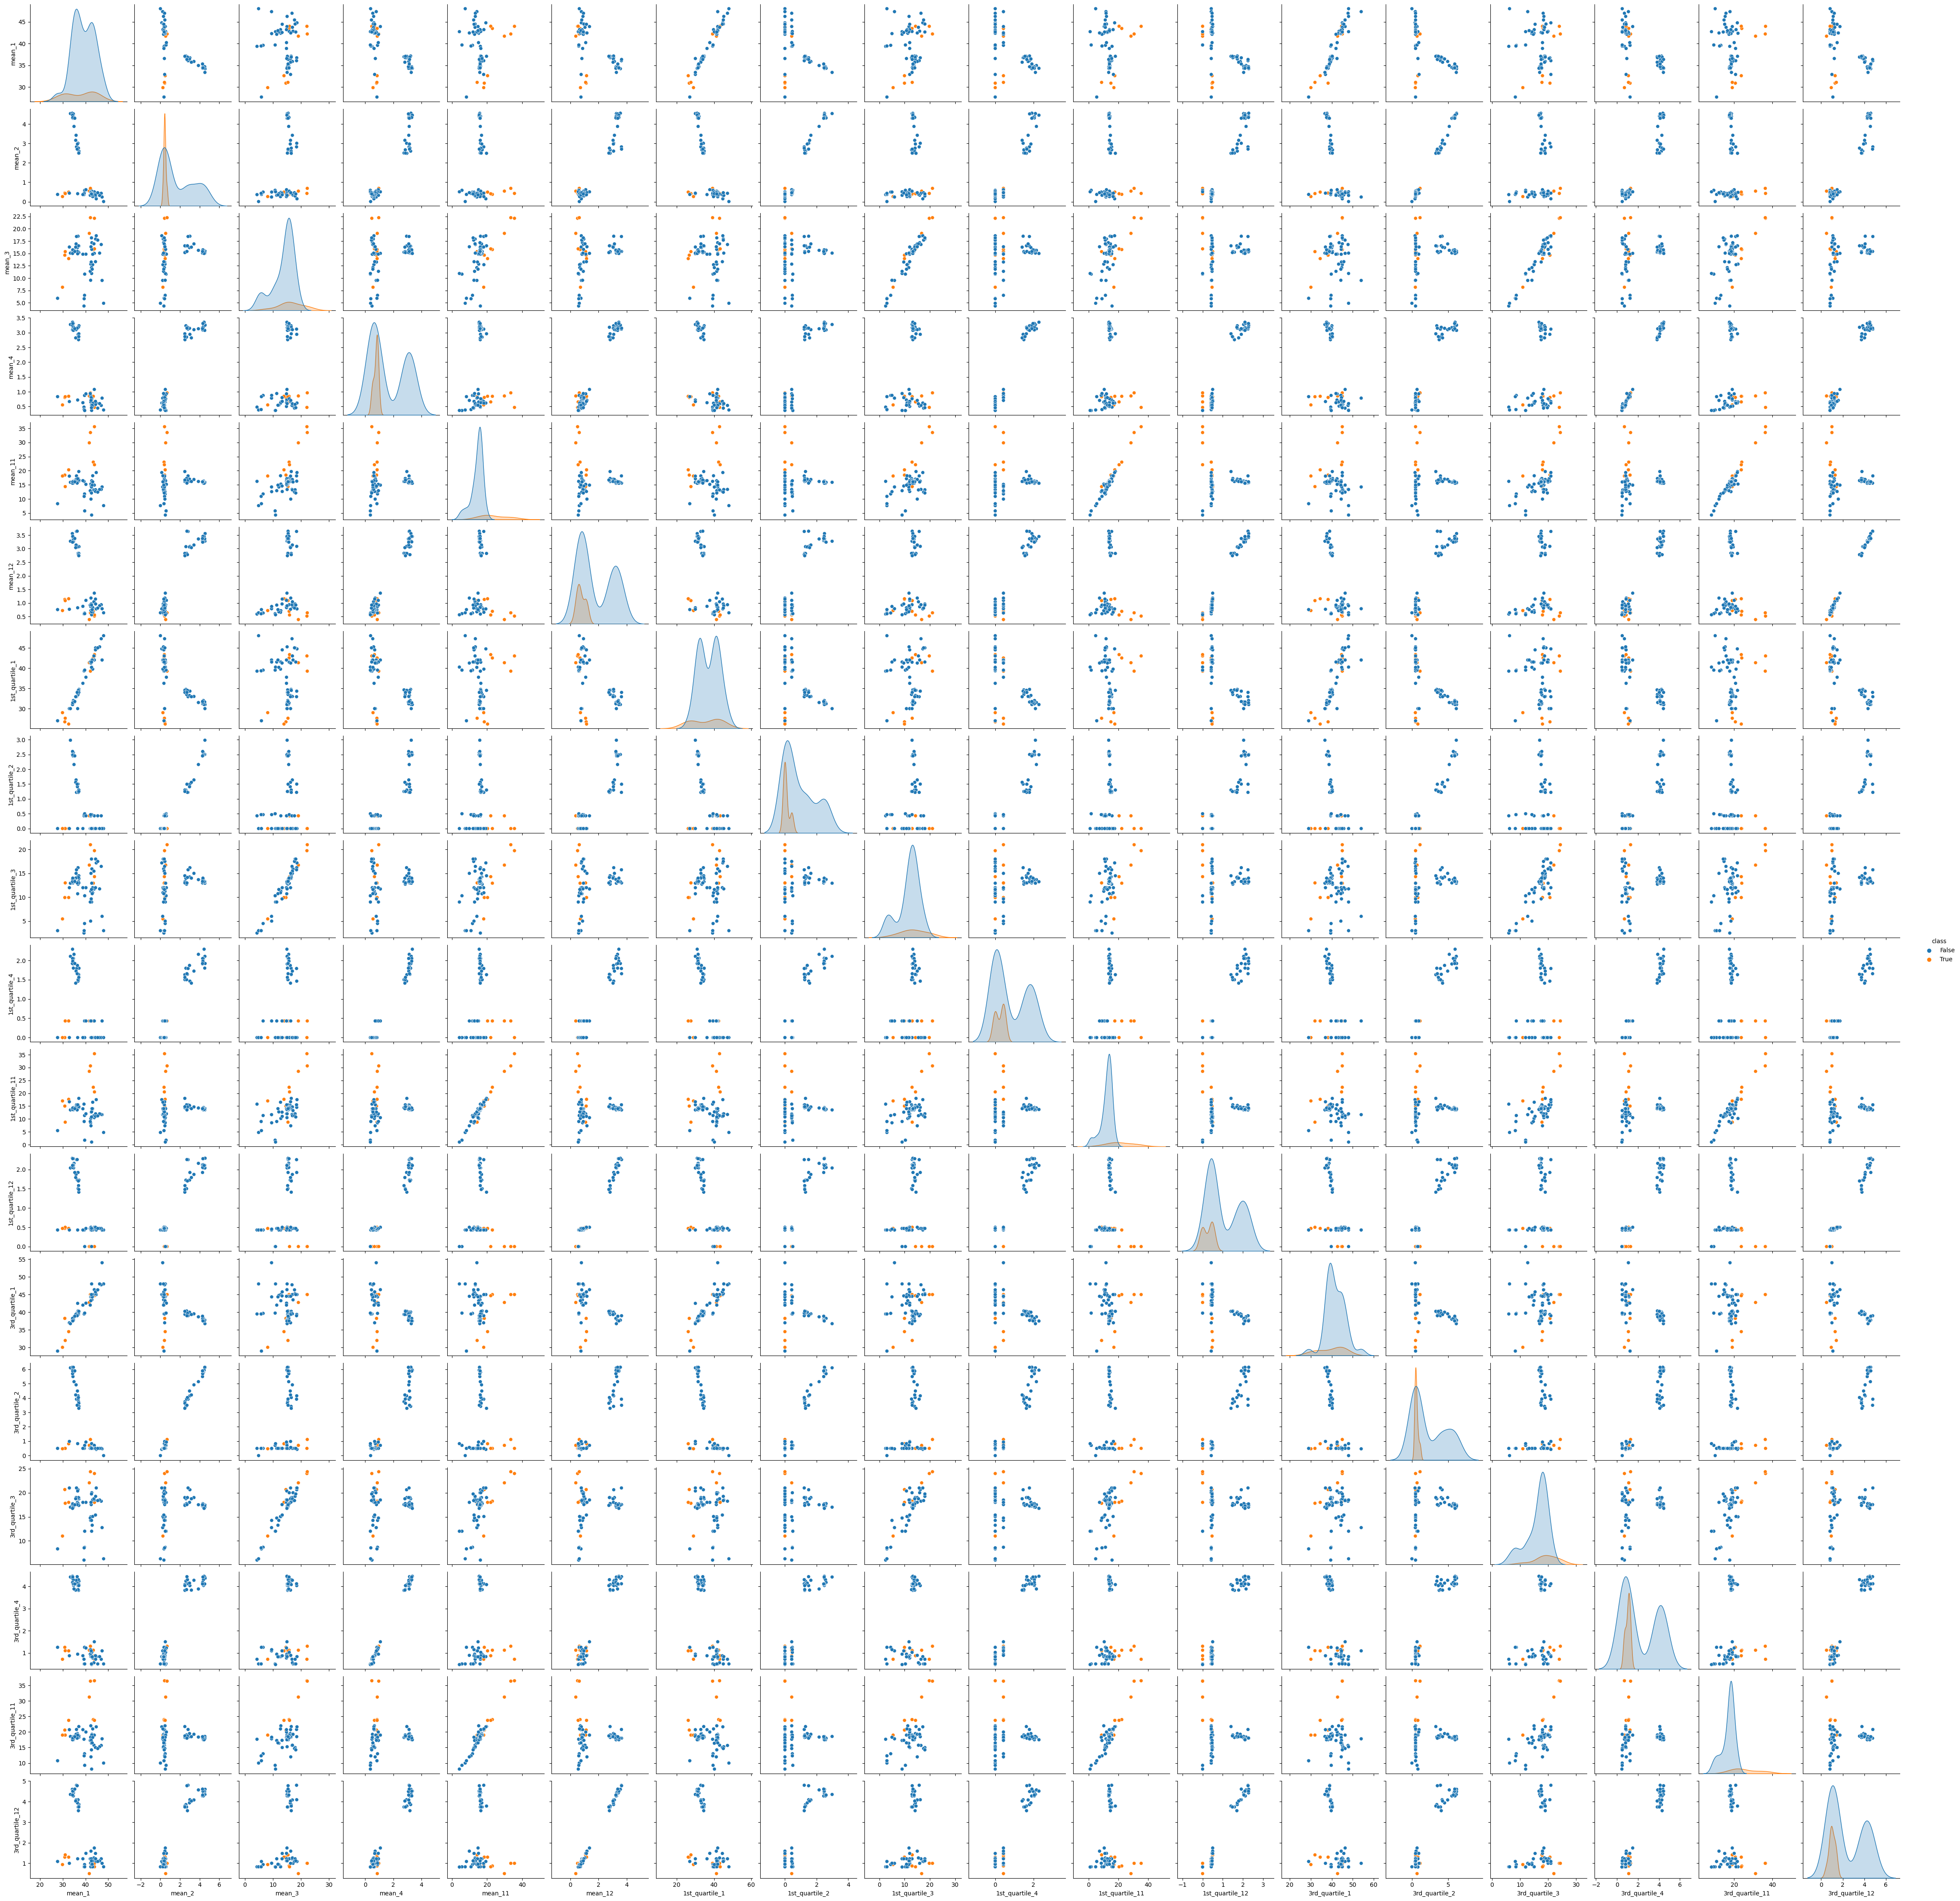

In [19]:
sns.pairplot(df_selected, hue='class') 

**Do you see any considerable difference?**
> There is no considerable difference between the two.

## (a-iii) Break each time series in your training set into l in set {1, 2, ..., 20} time series of approximately ...

In [20]:
def logistic_regression(X, y, fold_count):
    logreg = LogisticRegression(penalty=None)
    # validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=Random_state)
    # rfecv  = RFECV(estimator=logreg, cv=validator, scoring='accuracy')
    rfecv  = RFECV(estimator=logreg, cv=fold_count)
    
    # Fit the selector with the scaled features
    rfecv.fit(X, y)

    return logreg, rfecv 

In [21]:
l_p_pair = []
train_score = []
all_models = []
all_selectors = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    df_L_trian['class'] = (df_L_trian['Label'] == 'bending1') | (df_L_trian['Label'] == 'bending2')
    
    X_trian_ready = df_L_trian.drop(['class','Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    y_trian_ready = df_L_trian['class']
    
    # train the logreg model
    model, selector = logistic_regression(X_trian_ready, y_trian_ready, fold_count = k_fold)
    
    # all_models.append(model)
    all_selectors.append(selector)
    
    p = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    l_p_pair.append((l, p))
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    'pair(l, p)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1


fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


pair(l, p)  Accuracy
0      (1, 6)       1.0
1      (2, 7)       1.0
2     (3, 11)       1.0
3      (4, 9)       1.0
4      (5, 7)       1.0
5      (6, 9)       1.0
6     (7, 11)       1.0
7      (8, 8)       1.0
8     (9, 12)       1.0
9    (10, 18)       1.0
10   (11, 38)       1.0
11    (12, 6)       1.0
12   (13, 35)       1.0
13    (14, 8)       1.0
14   (15, 14)       1.0
15    (16, 7)       1.0
16   (17, 11)       1.0
17   (18, 35)       1.0
18   (19, 38)       1.0
19    (20, 6)       1.0

**Explain what the right way and the wrong way:**

> - The correct way is to do the Recursive Feature Elimination along with Cross Validation.
> - Doing RFE before performing Cross Validation is the wrong way.

## (a-iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression betas as well as the p-values associated with them.

In [22]:
# finding the best pair (l,p)
i = np.argmax(train_score)
best_l, best_p = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_df_trian['class'] = (best_df_trian['Label'] == 'bending1') | (best_df_trian['Label'] == 'bending2')

best_X_trian = best_df_trian.drop(['class','Label'], axis=1)
best_X_trian = np.array(best_X_trian)

best_y_trian = np.array(best_df_trian['class'])
    
# best model
# best_model = all_models[i]
best_slector = all_selectors[i]
best_X_train_selected = best_slector.transform(best_X_trian)


Report the confusion matrix 

In [23]:
# Make predictions using the logistic regression model
y_pred = best_slector.estimator_.predict(best_X_train_selected)

cm = confusion_matrix(best_y_trian, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[60  0]
 [ 0  9]]


show the ROC and AUC for your classifier
on train data

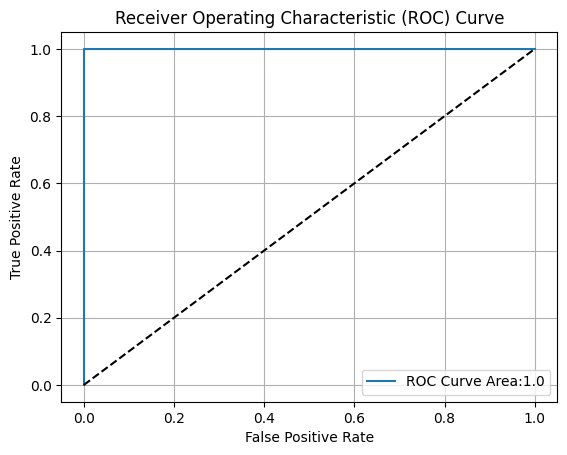

In [24]:
y_predict_proba = best_slector.estimator_.predict_proba(best_X_train_selected)

fpr, tpr, thresholds = roc_curve(best_y_trian, y_predict_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend(['ROC Curve Area:' + str(round(roc_auc, 4))])
plt.grid(True)
plt.show()


Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [25]:
# selected features
selecetd_featur = best_slector.support_
x = best_X_trian[:,selecetd_featur]

X_with_const = sm.add_constant(x)
logmodel = sm.Logit(best_y_trian, X_with_const)
summary = logmodel.fit(method='bfgs').summary()
print(summary)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                   1.000
Time:                        20:56:20   Log-Likelihood:            -8.8388e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7799   1.52e+07  -5.1

## (a-v) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [26]:
# generate test features
best_df_test = feature_maker(X_test, y_test, L=best_l)
best_df_test['class'] = (best_df_test['Label'] == 'bending1') | (best_df_test['Label'] == 'bending2')

best_X_test = best_df_test.drop(['class','Label'], axis=1)
best_X_test = np.array(best_X_test)

best_y_test = np.array(best_df_test['class'])

# predict
best_X_test_selected = best_slector.transform(best_X_test)
y_pred = best_slector.estimator_.predict(best_X_test_selected)

# confusion matrix
cm = confusion_matrix(best_y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0]
 [ 0  4]]


**Compare the accuracy:**
> The accuracy for test is same.

## (a-vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

> - The p-value analysis shows that there is Complete Separation. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.
> - It is possible that the well-separation of the classes is cauisng the instability in calculation of the regression parameters.

## (a-vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

I can see, according to the confusion matrices, that there are 69 instances of non-bending classes and 9 instances for bending classes which goes to show that the classes are definitely imbalanced.

In [27]:
# Logistic Regression with oversampling
l_p_pair = []
train_score = []
all_models = []
all_selectors = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    df_L_trian['class'] = (df_L_trian['Label'] == 'bending1') | (df_L_trian['Label'] == 'bending2')
    
    # oversampling
    ros = RandomOverSampler(random_state=Random_state)
    df_L_trian_resampled , y_trian_ready =  ros.fit_resample(df_L_trian, df_L_trian['class'])
    X_trian_ready = df_L_trian_resampled.drop(['class','Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    
    # train the logreg model
    model, selector = logistic_regression(X_trian_ready, y_trian_ready, fold_count = k_fold)
    
    # all_models.append(model)
    all_selectors.append(selector)
    
    p = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    l_p_pair.append((l, p))
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    'pair(l, p)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1
fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


pair(l, p)  Accuracy
0     (1, 11)  0.983333
1      (2, 4)  0.991667
2      (3, 6)  0.991667
3     (4, 19)  1.000000
4      (5, 5)  1.000000
5     (6, 14)  1.000000
6      (7, 3)  1.000000
7     (8, 60)  1.000000
8      (9, 5)  1.000000
9    (10, 12)  1.000000
10   (11, 74)  1.000000
11   (12, 10)  1.000000
12    (13, 6)  1.000000
13   (14, 74)  1.000000
14    (15, 4)  1.000000
15   (16, 19)  1.000000
16    (17, 5)  1.000000
17   (18, 13)  1.000000
18    (19, 8)  1.000000
19   (20, 14)  1.000000

In [28]:
# finding the best pair (l,p)
i = np.argmax(train_score)
best_l, best_p = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_df_trian['class'] = (best_df_trian['Label'] == 'bending1') | (best_df_trian['Label'] == 'bending2')

best_X_trian = best_df_trian.drop(['class','Label'], axis=1)
best_X_trian = np.array(best_X_trian)

best_y_trian = np.array(best_df_trian['class'])
    
# best model
# best_model = all_models[i]
best_slector = all_selectors[i]
best_X_train_selected = best_slector.transform(best_X_trian)


Report the confusion matrix 

In [29]:
# Make predictions using the logistic regression model
y_pred = best_slector.estimator_.predict(best_X_train_selected)

cm = confusion_matrix(best_y_trian, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[60  0]
 [ 0  9]]


show the ROC and AUC for your classifier
on train data

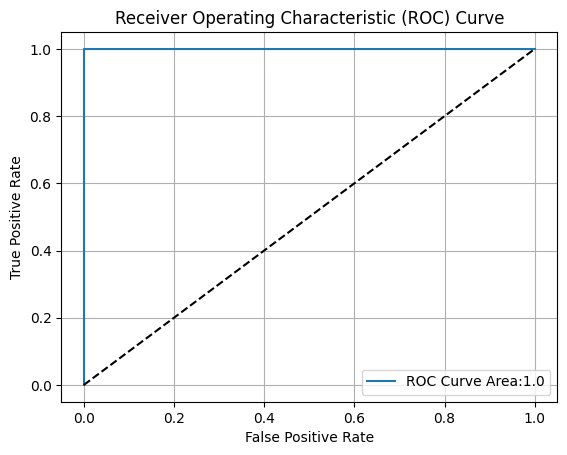

In [30]:
y_predict_proba = best_slector.estimator_.predict_proba(best_X_train_selected)

fpr, tpr, thresholds = roc_curve(best_y_trian, y_predict_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend(['ROC Curve Area:' + str(round(roc_auc, 4))])
plt.grid(True)
plt.show()


# (b) Binary Classification Using L1-penalized logistic regression

## (2i) Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selec...

In [31]:
l_p_pair = []
train_score = []
all_classifier = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    df_L_trian['class'] = (df_L_trian['Label'] == 'bending1') | (df_L_trian['Label'] == 'bending2')
    
    X_trian_ready = df_L_trian.drop(['class','Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    y_trian_ready = df_L_trian['class']
    
    # train the logreg model
    classifier =  LogisticRegressionCV(cv=5, penalty='l1', scoring='accuracy', solver='liblinear')
    classifier.fit(X_trian_ready, y_trian_ready)
    
    # all_models.append(model)
    all_classifier.append(classifier)
    
    p = (classifier.coef_ > 0.000000001).sum()
    score = classifier.score(X_trian_ready, y_trian_ready)
    l_p_pair.append((l, p))
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    'pair(l, p)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1
fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


pair(l, p)  Accuracy
0      (1, 3)       1.0
1      (2, 3)       1.0
2      (3, 5)       1.0
3      (4, 3)       1.0
4      (5, 7)       1.0
5      (6, 9)       1.0
6     (7, 10)       1.0
7      (8, 8)       1.0
8      (9, 6)       1.0
9    (10, 12)       1.0
10    (11, 7)       1.0
11   (12, 14)       1.0
12   (13, 32)       1.0
13   (14, 14)       1.0
14    (15, 6)       1.0
15    (16, 7)       1.0
16   (17, 18)       1.0
17   (18, 24)       1.0
18  (19, 125)       1.0
19   (20, 38)       1.0

In [32]:
# finding the best pair (l,p)
i = np.argmax(train_score)
best_l, best_p = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_df_trian['class'] = (best_df_trian['Label'] == 'bending1') | (best_df_trian['Label'] == 'bending2')

best_X_trian = best_df_trian.drop(['class','Label'], axis=1)
best_X_trian = np.array(best_X_trian)

best_y_trian = np.array(best_df_trian['class'])
    
# best model
best_classifier = all_classifier[i]


In [33]:
# Make predictions using the logistic regression model
y_pred = best_classifier.predict(best_X_trian)

cm = confusion_matrix(best_y_trian, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[60  0]
 [ 0  9]]


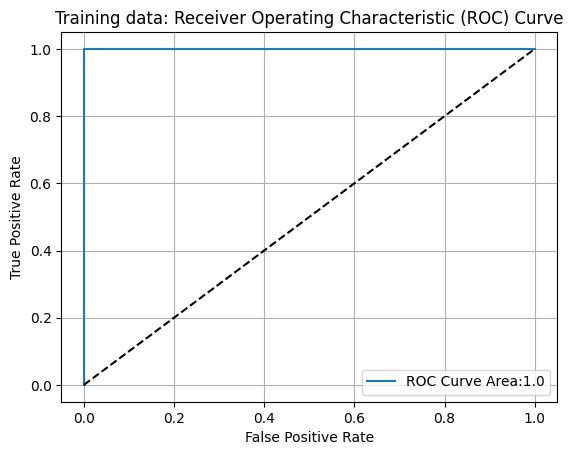

In [34]:
y_predict_proba = best_classifier.predict_proba(best_X_trian)

fpr, tpr, thresholds = roc_curve(best_y_trian, y_predict_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training data: Receiver Operating Characteristic (ROC) Curve')

plt.legend(['ROC Curve Area:' + str(round(roc_auc, 4))])
plt.grid(True)
plt.show()


FOR TEST DATA:


In [35]:
# generate test features
best_df_test = feature_maker(X_test, y_test, L=best_l)
best_df_test['class'] = (best_df_test['Label'] == 'bending1') | (best_df_test['Label'] == 'bending2')

best_X_test = best_df_test.drop(['class','Label'], axis=1)
best_X_test = np.array(best_X_test)

best_y_test = np.array(best_df_test['class'])

# predict
y_pred = best_classifier.predict(best_X_test)

# confusion matrix
cm = confusion_matrix(best_y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0]
 [ 0  4]]


## (b-ii) Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [36]:
# selected features
selecetd_featur = best_classifier.coef_ > 0.000000001
x = best_X_trian[:,selecetd_featur.flatten()]

X_with_const = sm.add_constant(x)
logmodel = sm.Logit(best_y_trian, X_with_const)
summary = logmodel.fit(method='bfgs').summary()
print(summary)

         Current function value: 0.000364
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                  0.9991
Time:                        21:21:27   Log-Likelihood:              -0.025083
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.518e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -542.4246   3.14e+05     -0.002      0.999   -6.15e+05    6.14e+

**answer:**
> - The L1-regularization is easier to implement. 
> - The accuraciy is the same.
> - P-values are lower in L1-regularization.
> - number of selected variables are lower in L1-regularization.

I personally like L1-regularization more.

## (c) Multi-class Classification (The Realistic Case)

## (c-i) Find the best l in the same way as you found it in 2(b)i to build an ...

In [88]:
l_p_pair = []
train_score = []
all_classifier = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    
    # oversampling
    ros = RandomOverSampler(random_state=Random_state)
    df_L_trian_resampled , y_trian_over =  ros.fit_resample(df_L_trian, df_L_trian['Label'])
    X_trian_over = df_L_trian_resampled.drop(['Label'], axis=1)
    X_trian_over = np.array(X_trian_over)
    
    # train the logreg model
    classifier =  LogisticRegressionCV(max_iter=2000,cv=5, penalty='l1', scoring='accuracy', solver='saga', multi_class= 'multinomial')
    classifier.fit(X_trian_over, y_trian_over)
    
    # all_models.append(model)
    all_classifier.append(classifier)
    
    # predict
    df_L_trian = feature_maker(X_train, y_train, L=l)
    X_trian_ready = df_L_trian.drop(['Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    y_trian_ready = df_L_trian['Label']
    
    p = (classifier.coef_ > 0.000000001).sum()
    score = classifier.score(X_trian_ready, y_trian_ready)
    l_p_pair.append((l, p))
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    'pair(l, p)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1
fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


pair(l, p)  Accuracy
0      (1, 67)       1.0
1     (2, 137)       1.0
2     (3, 189)       1.0
3     (4, 279)       1.0
4     (5, 367)       1.0
5     (6, 418)       1.0
6     (7, 488)       1.0
7     (8, 613)       1.0
8     (9, 667)       1.0
9    (10, 775)       1.0
10   (11, 749)       1.0
11   (12, 217)       1.0
12   (13, 239)       1.0
13   (14, 999)       1.0
14  (15, 1097)       1.0
15  (16, 1208)       1.0
16  (17, 1173)       1.0
17   (18, 284)       1.0
18  (19, 1387)       1.0
19   (20, 316)       1.0

In [89]:
def multiclass_result_plot(y_true, y_pred, y_prob):
    #print('ploting...')
    # Convert string labels to numerical values
    labels = np.unique(y_true)
    label_to_index = {label: i for i, label in enumerate(labels)}
    y_true_numeric = np.array([label_to_index[label] for label in y_true])
    y_pred_numeric = np.array([label_to_index[label] for label in y_pred])

    # Compute confusion matrix
    cm = confusion_matrix(y_true_numeric, y_pred_numeric)

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    # Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Convert y_true and y_pred to one-hot encoding
    one_hot_y_true = np.eye(len(labels))[y_true_numeric]
    one_hot_y_pred = np.eye(len(labels))[y_pred_numeric]

    # Compute ROC curve and AUC for each class
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_y_true[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    for i in range(len(labels)):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:.2f})'.format(labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [90]:
# finding the best pair (l,p)
i = np.argmax(train_score)
best_l, best_p = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_X_trian = best_df_trian.drop(['Label'], axis=1)
best_X_trian = np.array(best_X_trian)
best_y_trian = best_df_trian['Label']
    
# best model
best_classifier = all_classifier[i]

Trainig data-set


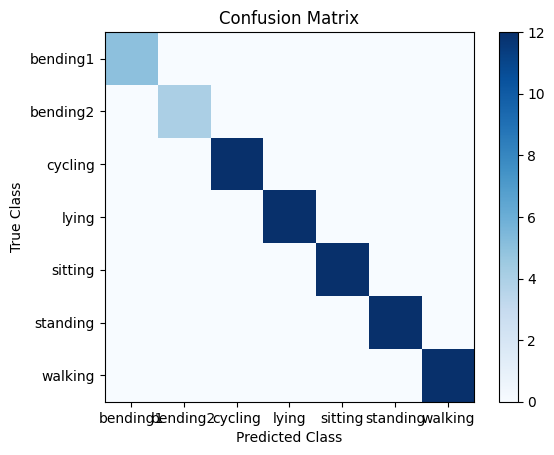

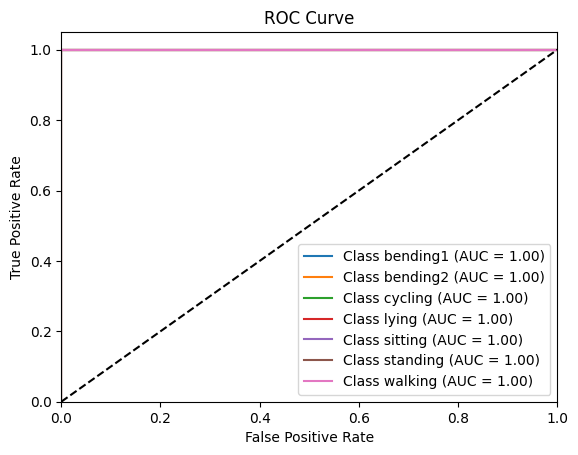

In [91]:
print('Trainig data-set')
multiclass_result_plot(y_true = best_y_trian, y_pred = best_classifier.predict(best_X_trian), y_prob = best_classifier.predict_proba(best_X_trian))

In [92]:
# TEST dataset
# generate new features
best_df_test = feature_maker(X_test, y_test, L=best_l)
best_X_test = best_df_test.drop(['Label'], axis=1)
best_X_test = np.array(best_X_test)
best_y_test = best_df_test['Label']
    
# best model
best_classifier = all_classifier[i]

Test data-set


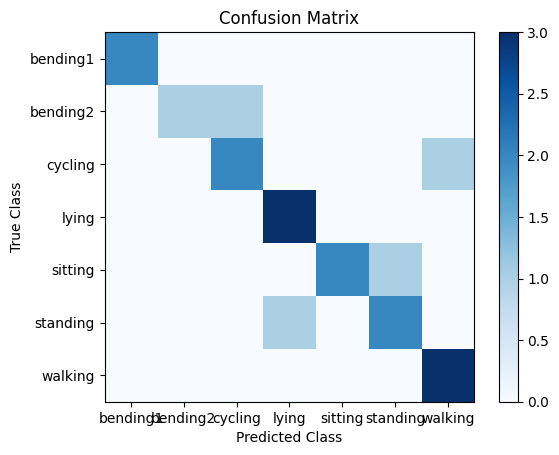

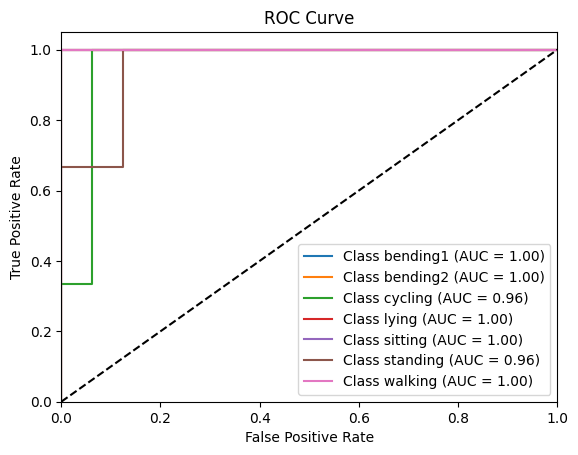

In [93]:
print('Test data-set')
multiclass_result_plot(y_true = best_y_test, y_pred = best_classifier.predict(best_X_test), y_prob = best_classifier.predict_proba(best_X_test))

## (c-ii) Repeat 2(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

Gaussian

In [94]:
l_p_pair = []
train_score = []
all_classifier = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    
    # oversampling
    ros = RandomOverSampler(random_state=Random_state)
    df_L_trian_resampled , y_trian_over =  ros.fit_resample(df_L_trian, df_L_trian['Label'])
    X_trian_over = df_L_trian_resampled.drop(['Label'], axis=1)
    X_trian_over = np.array(X_trian_over)
    
    # train the logreg model
    classifier =  GaussianNB()
    classifier.fit(X_trian_over, y_trian_over)
    
    # all_models.append(model)
    all_classifier.append(classifier)
    
    # predict
    df_L_trian = feature_maker(X_train, y_train, L=l)
    X_trian_ready = df_L_trian.drop(['Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    y_trian_ready = df_L_trian['Label']
    
    score = classifier.score(X_trian_ready, y_trian_ready)
    l_p_pair.append(l)
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    '(l)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1
fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


(l)  Accuracy
0     1  0.985507
1     2  1.000000
2     3  0.985507
3     4  1.000000
4     5  0.985507
5     6  0.985507
6     7  0.985507
7     8  1.000000
8     9  1.000000
9    10  0.985507
10   11  1.000000
11   12  0.985507
12   13  1.000000
13   14  1.000000
14   15  0.985507
15   16  1.000000
16   17  0.985507
17   18  1.000000
18   19  0.985507
19   20  1.000000

In [95]:
# finding the best pair (l)
i = np.argmax(train_score)
best_l = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_X_trian = best_df_trian.drop(['Label'], axis=1)
best_X_trian = np.array(best_X_trian)
best_y_trian = best_df_trian['Label']
    
# best model
best_classifier = all_classifier[i]

Trainig data-set


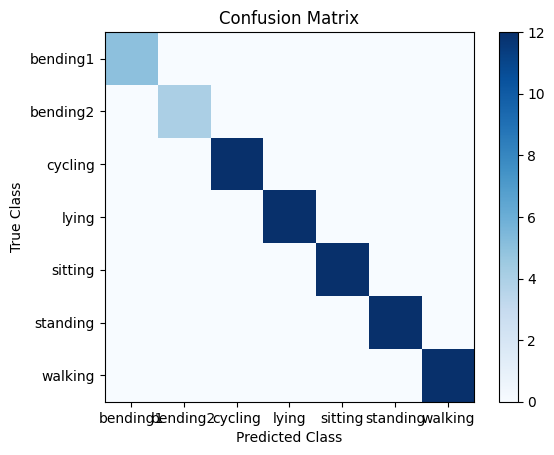

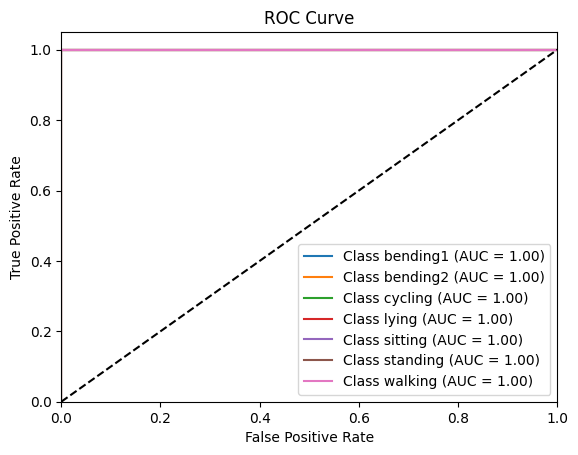

In [96]:
print('Trainig data-set')
multiclass_result_plot(y_true = best_y_trian, y_pred = best_classifier.predict(best_X_trian), y_prob = best_classifier.predict_proba(best_X_trian))

In [97]:
# TEST dataset
# generate new features
best_df_test = feature_maker(X_test, y_test, L=best_l)
best_X_test = best_df_test.drop(['Label'], axis=1)
best_X_test = np.array(best_X_test)
best_y_test = best_df_test['Label']
    
# best model
best_classifier = all_classifier[i]

Test data-set


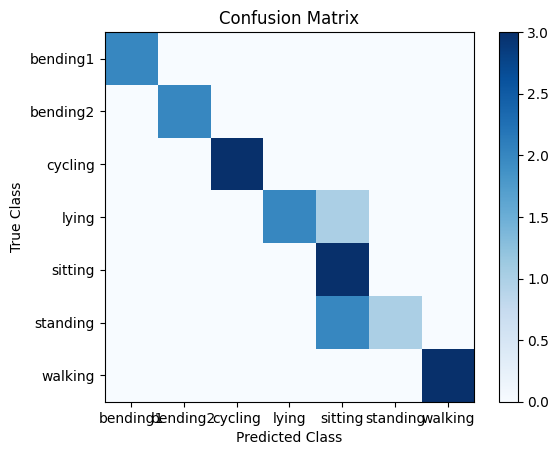

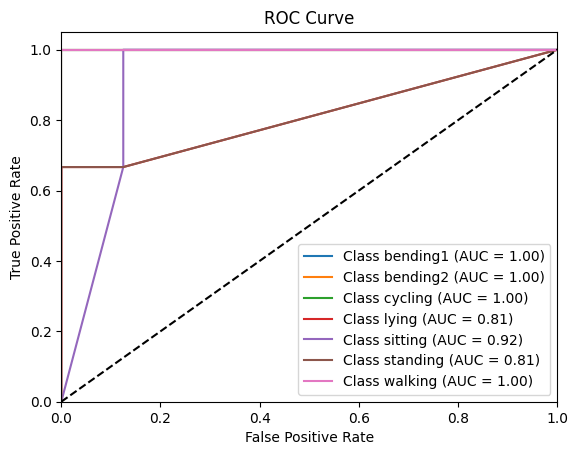

In [98]:
print('Test data-set')
multiclass_result_plot(y_true = best_y_test, y_pred = best_classifier.predict(best_X_test),  y_prob = best_classifier.predict_proba(best_X_test))

MultinomialNB

In [99]:
l_p_pair = []
train_score = []
all_classifier = []

k_fold = 5
L_list = list(range(1, 21)) 
for l in L_list:
    print('fitting to l = '+str(l))
    
    # generate new features
    df_L_trian = feature_maker(X_train, y_train, L=l)
    
    # oversampling
    ros = RandomOverSampler(random_state=Random_state)
    df_L_trian_resampled , y_trian_over =  ros.fit_resample(df_L_trian, df_L_trian['Label'])
    X_trian_over = df_L_trian_resampled.drop(['Label'], axis=1)
    X_trian_over = np.array(X_trian_over)
    
    # train the logreg model
    classifier =  MultinomialNB()
    classifier.fit(X_trian_over, y_trian_over)
    
    # all_models.append(model)
    all_classifier.append(classifier)
    
    # predict
    df_L_trian = feature_maker(X_train, y_train, L=l)
    X_trian_ready = df_L_trian.drop(['Label'], axis=1)
    X_trian_ready = np.array(X_trian_ready)
    y_trian_ready = df_L_trian['Label']
    
    score = classifier.score(X_trian_ready, y_trian_ready)
    l_p_pair.append(l)
    train_score.append(score)
    
    # print(selector.ranking_)
    # print(selector.support_)
    
df = pd.DataFrame({
    '(l)': l_p_pair,
    'Accuracy': train_score
})
    
df    
    

fitting to l = 1
fitting to l = 2
fitting to l = 3
fitting to l = 4
fitting to l = 5
fitting to l = 6
fitting to l = 7
fitting to l = 8
fitting to l = 9
fitting to l = 10
fitting to l = 11
fitting to l = 12
fitting to l = 13
fitting to l = 14
fitting to l = 15
fitting to l = 16
fitting to l = 17
fitting to l = 18
fitting to l = 19
fitting to l = 20


(l)  Accuracy
0     1  0.927536
1     2  0.913043
2     3  0.898551
3     4  0.913043
4     5  0.927536
5     6  0.898551
6     7  0.898551
7     8  0.913043
8     9  0.913043
9    10  0.927536
10   11  0.927536
11   12  0.927536
12   13  0.927536
13   14  0.913043
14   15  0.927536
15   16  0.913043
16   17  0.927536
17   18  0.927536
18   19  0.927536
19   20  0.913043

In [100]:
# finding the best pair (l)
i = np.argmax(train_score)
best_l = l_p_pair[i]

# generate new features
best_df_trian = feature_maker(X_train, y_train, L=best_l)
best_X_trian = best_df_trian.drop(['Label'], axis=1)
best_X_trian = np.array(best_X_trian)
best_y_trian = best_df_trian['Label']
    
# best model
best_classifier = all_classifier[i]

Trainig data-set


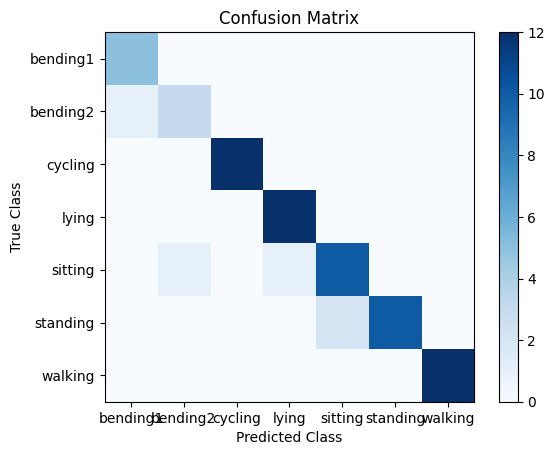

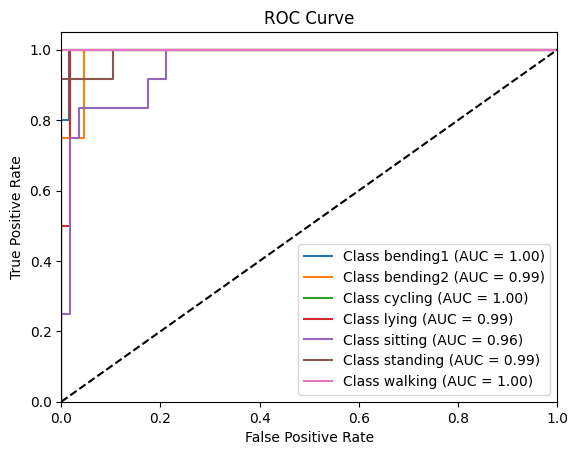

In [101]:
print('Trainig data-set')
multiclass_result_plot(y_true = best_y_trian, y_pred = best_classifier.predict(best_X_trian) , y_prob=best_classifier.predict_proba(best_X_trian))


In [102]:
# TEST dataset
# generate new features
best_df_test = feature_maker(X_test, y_test, L=best_l)
best_X_test = best_df_test.drop(['Label'], axis=1)
best_X_test = np.array(best_X_test)
best_y_test = best_df_test['Label']
    
# best model
best_classifier = all_classifier[i]

Test data-set


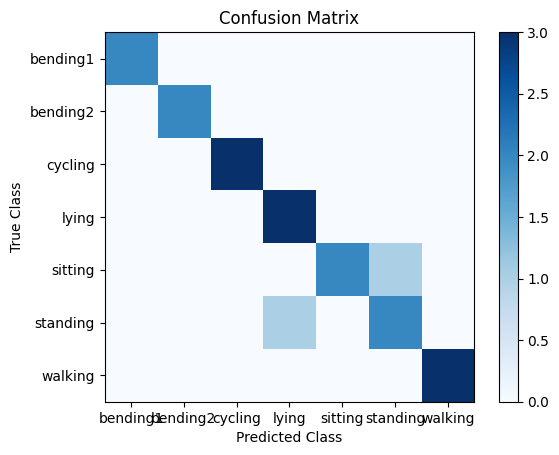

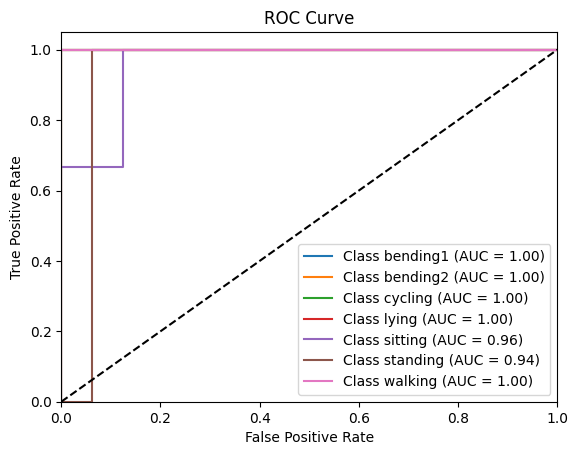

In [103]:
print('Test data-set')
multiclass_result_plot(y_true = best_y_test, y_pred = best_classifier.predict(best_X_test),  y_prob = best_classifier.predict_proba(best_X_test))

## (c-iii) Which method is better for multi-class classification in this problem?


> The AUC is better for the Logistic Regression curve the other two.